<a href="https://colab.research.google.com/github/SyedSihabUsSakib/Thesis/blob/master/Copy_of_gated_reccurent_unit_level_two.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Libraries

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import seaborn as sns
import re,nltk,json
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras import models
from keras import layers
from tensorflow.keras.layers import LSTM,GRU
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report 
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,roc_auc_score
from sklearn.metrics import average_precision_score,roc_auc_score, roc_curve, precision_recall_curve
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
np.random.seed(42)
class color: # Text style
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'
# dataset path
path = '/content/drive/My Drive/Colab Notebooks'

# Data Preparation

Total number of political texts: 2751


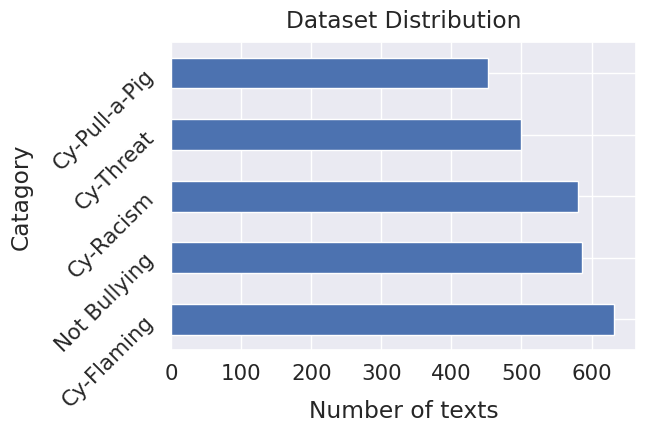

In [ ]:
data = pd.read_csv(path+'/dataset.csv',encoding='utf-8')
print(f'Total number of political texts: {len(data)}')
sns.set(font_scale=1.4)
data['label'].value_counts().plot(kind='barh', figsize=(6, 4))
plt.xlabel("Number of texts", labelpad=12)
plt.ylabel("Catagory", labelpad=12)
plt.yticks(rotation = 45)
plt.title("Dataset Distribution", y=1.02);

# Data Cleaning

In [ ]:
def cleaning_data(row):
      headlines = re.sub('[^\u0980-\u09FF]',' ',str(row)) #removing unnecessary punctuation
      return headlines
# Apply the function into the dataframe
data['cleaned'] = data['text'].apply(cleaning_data)  

# print some cleaned reviews from the dataset
sample_data = [50,150,800,1500]
for i in sample_data:
  print('Original: ',data.text[i],'\nCleaned:',
           data.cleaned[i],'\n','Category:-- ',data.label[i],'\n')   
     

Original:  কোন গুদামের আটা খেয়ে এত মোটা হয় হইছিস 
Cleaned: কোন গুদামের আটা খেয়ে এত মোটা হয় হইছিস 
 Category:--  Cy-Pull-a-Pig 

Original:  সংসদকে নাট্যশালা বানাইছে এই মহিলা 
Cleaned: সংসদকে নাট্যশালা বানাইছে এই মহিলা 
 Category:--  Cy-Flaming 

Original:  কই থেকে আসে এইসব পতিতারা 
Cleaned: কই থেকে আসে এইসব পতিতারা 
 Category:--  Cy-Flaming 

Original:  কি লিপস্টিক লাগাও নাকি ঠোঁট এত গোলাপি কেন 
Cleaned: কি লিপস্টিক লাগাও নাকি ঠোঁট এত গোলাপি কেন 
 Category:--  Cy-Pull-a-Pig 



# Remove Low Length Data(cross)

In [ ]:
# Length of each headlines
data['length'] = data['cleaned'].apply(lambda x:len(x.split()))
# Remove the headlines with least words
dataset = data.loc[data.length>2]
dataset = dataset.reset_index(drop = True)
print("After Cleaning:","\nRemoved {} Small Texts".format(len(data)-len(dataset)),
      "\nTotal texts:",len(dataset))

After Cleaning: 
Removed 118 Small Texts 
Total texts: 2633


# Dataset Analysis

In [ ]:

def data_summary(dataset):
    
    """
    This function will print the summary of the headlines and words distribution in the dataset. 
    
    Args:
        dataset: list of cleaned sentences   
        
    Returns:
        Number of documnets per class: int 
        Number of words per class: int
        Number of unique words per class: int
    """
    documents = []
    words = []
    u_words = []
    total_u_words = [word.strip().lower() for t in list(dataset.cleaned) for word in t.strip().split()]
    class_label= [k for k,v in dataset.label.value_counts().to_dict().items()]
  # find word list
    for label in class_label: 
        word_list = [word.strip().lower() for t in list(dataset[dataset.label==label].cleaned) for word in t.strip().split()]
        counts = dict()
        for word in word_list:
                counts[word] = counts.get(word, 0)+1
        # sort the dictionary of word list  
        ordered = sorted(counts.items(), key= lambda item: item[1],reverse = True)
        # Documents per class
        documents.append(len(list(dataset[dataset.label==label].cleaned)))
        # Total Word per class
        words.append(len(word_list))
        # Unique words per class 
        u_words.append(len(np.unique(word_list)))
       
        print("\nClass Name : ",label)
        print("Number of Documents:{}".format(len(list(dataset[dataset.label==label].cleaned))))  
        print("Number of Words:{}".format(len(word_list))) 
        print("Number of Unique Words:{}".format(len(np.unique(word_list)))) 
        print("Most Frequent Words:\n")
        for k,v in ordered[:10]:
              print("{}\t{}".format(k,v))
    print("Total Number of Unique Words:{}".format(len(np.unique(total_u_words))))           
   
    return documents,words,u_words,class_label

#call the fucntion
documents,words,u_words,class_names = data_summary(dataset)    



Class Name :  Not Bullying
Number of Documents:575
Number of Words:5871
Number of Unique Words:2259
Most Frequent Words:

ভালো	74
অনেক	68
আপনার	64
ভাই	63
না	56
সুন্দর	55
করে	48
আল্লাহ	48
হিরো	44
জন্য	44

Class Name :  Cy-Racism
Number of Documents:573
Number of Words:6081
Number of Unique Words:2307
Most Frequent Words:

এই	96
করে	80
না	71
আর	64
হিন্দু	52
মুসলিম	47
ধর্ম	42
জাতি	38
তোর	37
জাপানি	35

Class Name :  Cy-Flaming
Number of Documents:553
Number of Words:3628
Number of Unique Words:1659
Most Frequent Words:

এই	76
না	39
তুই	33
তোর	32
একটা	28
করে	27
আর	26
কি	24
খারাপ	22
বাচ্চা	22

Class Name :  Cy-Threat
Number of Documents:498
Number of Words:4528
Number of Unique Words:1688
Most Frequent Words:

তোর	156
করে	61
না	61
এই	55
হবে	51
দরকার	42
তোকে	42
তোদের	33
দিয়ে	32
উচিত	32

Class Name :  Cy-Pull-a-Pig
Number of Documents:434
Number of Words:3107
Number of Unique Words:1271
Most Frequent Words:

না	86
মত	85
তোর	77
এত	62
তো	42
কেন	38
তুই	38
করে	29
আর	28
তোমার	28
Total Number of U

# Summary Visualization

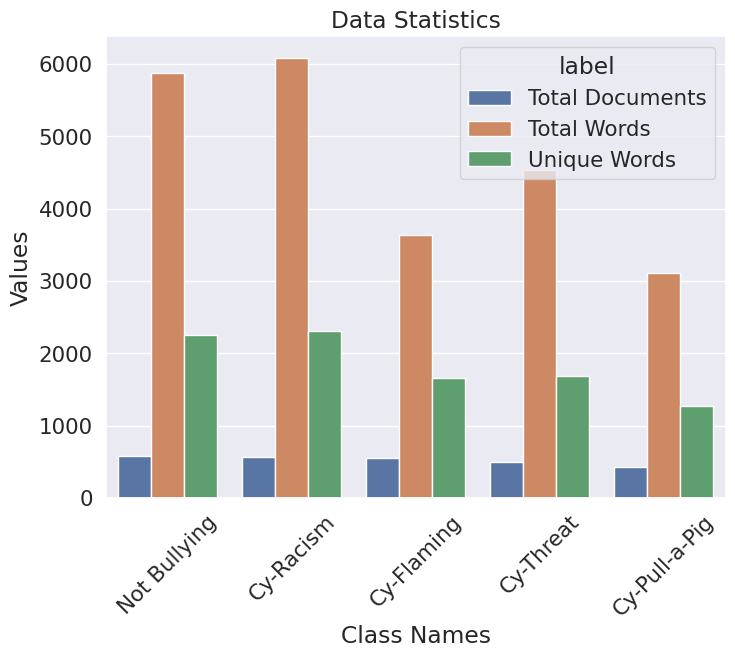

In [ ]:
data_matrix = pd.DataFrame({'Total Documents':documents,
                            'Total Words':words,
                            'Unique Words':u_words,
                            'Class Names':class_names})
df = pd.melt(data_matrix, id_vars="Class Names", var_name="label", value_name="Values")
plt.figure(figsize=(8, 6))
ax = plt.subplot()

sns.barplot(data=df,x='Class Names', y='Values' ,hue='label')
ax.set_xlabel('Class Names') 
ax.set_title('Data Statistics')

ax.xaxis.set_ticklabels(class_names, rotation=45);

# Text Length Distribution

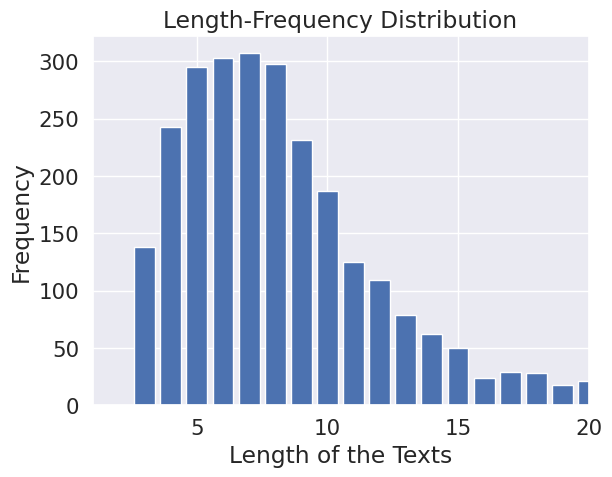

Maximum Length of a Text: 62
Minimum Length of a Text: 3
Average Length of a Text: 9.0


In [ ]:
# Calculate the Review of each of the Review
dataset['TextLength'] = dataset.cleaned.apply(lambda x:len(x.split()))
frequency = dict()
for i in dataset.TextLength:
    frequency[i] = frequency.get(i, 0)+1

plt.bar(frequency.keys(), frequency.values(), color ="b")
plt.xlim(1, 20)
# in this notbook color is not working but it should work.
plt.xlabel('Length of the Texts')
plt.ylabel('Frequency')
plt.title('Length-Frequency Distribution')
plt.show()  
print(f"Maximum Length of a Text: {max(dataset.TextLength)}")
print(f"Minimum Length of a Text: {min(dataset.TextLength)}")
print(f"Average Length of a Text: {round(np.mean(dataset.TextLength),0)}")
     

# NLable Encoding and Dataset Splitting

In [ ]:
                                       ################# Label Encoding Function #########
                                       #==================================================

def label_encoding(Category,bool):
    """
    This function will return the encoded labels in array format. 
    
    Args:
        category: series of class names(str)
        bool: boolean (True or False)
        
    Returns:
        labels: numpy array 
    """
    le = LabelEncoder()
    le.fit(Category)
    encoded_labels = le.transform(Category)
    labels = np.array(encoded_labels) # Converting into numpy array
    class_names =le.classes_ ## Define the class names again
    if bool == True:
        print("\n\t\t\t===== Label Encoding =====","\nClass Names:-->",le.classes_)
        for i in sample_data:
            print(Category[i],' ', encoded_labels[i],'\n')

    return labels



                           #===========================================================
                           ################# Dataset Splitting Function ###############
                           #=========================================================== 

def dataset_split(Text,Category):
    """
    This function will return the splitted (90%-10%-10%) feature vector . 
    
    Args:
        headlines: sequenced headlines 
        category: encoded lables (array) 
        
    Returns:
        X_train: training data 
        X_valid: validation data
        X_test : testing feature vector 
        y_train: training encoded labels (array) 
        y_valid: training encoded labels (array) 
        y_test : testing encoded labels (array) 
    """

    X,X_test,y,y_test = train_test_split(Text,Category,train_size = 0.9,
                                                  test_size = 0.1,random_state =0)
    X_train,X_valid,y_train,y_valid = train_test_split(X,y,train_size = 0.8,
                                                  test_size = 0.2,random_state =0)
    print(color.BOLD+"\nDataset Distribution:\n"+color.END)
    print("\tSet Name","\t\tSize")
    print("\t========\t\t======")

    print("\tFull\t\t\t",len(Text),
        "\n\tTraining\t\t",len(X_train),
        "\n\tTest\t\t\t",len(X_test),
        "\n\tValidation\t\t",len(X_valid))
  
    return X_train,X_valid,X_test,y_train,y_valid,y_test

In [ ]:
labels = label_encoding(dataset.label,True)


			===== Label Encoding ===== 
Class Names:--> ['Cy-Flaming' 'Cy-Pull-a-Pig' 'Cy-Racism' 'Cy-Threat' 'Not Bullying']
Cy-Flaming   0 

Cy-Flaming   0 

Cy-Threat   3 

Cy-Pull-a-Pig   1 



In [ ]:
X_train,X_valid,X_test,y_train,y_valid,y_test = dataset_split(dataset.text,labels)


Dataset Distribution:

	Set Name 		Size
	========		======
	Full			 2633 
	Training		 1895 
	Test			 264 
	Validation		 474


# Tokenization

In [ ]:
vocab_size = 6308
embedding_dim = 64
max_length = 109
trunc_type='post'
padding_type='post'
oov_tok = ""

def padded_texts(original,encoded,padded):
  '''
  print the samples padded headlines
  '''
  print(color.BOLD+"\n\t\t\t====== Encoded Sequences ======"+color.END,"\n")  
  print(original,"\n",encoded) 
  print(color.BOLD+"\n\t\t\t====== Paded Sequences ======\n"+color.END,original,"\n",padded) 
  

In [ ]:

# Train Data Tokenization
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(X_train)
word_index = tokenizer.word_index
train_sequences = tokenizer.texts_to_sequences(X_train)
train_padded = pad_sequences(train_sequences, padding=padding_type, maxlen=max_length)

In [ ]:
#============================== Tokenizer Info =================================
(word_counts,word_docs,word_index,document_count) = (tokenizer.word_counts,
                                                       tokenizer.word_docs,
                                                       tokenizer.word_index,
                                                       tokenizer.document_count)
def tokenizer_info(mylist,bool):
  ordered = sorted(mylist.items(), key= lambda item: item[1],reverse = bool)
  for w,c in ordered[:10]:
    print(w,"\t",c)
  #=============================== Print all the information =========================
print(color.BOLD+"\t\t\t====== Tokenizer Info ======"+color.END)   
print("Words --> Counts:")
tokenizer_info(word_counts,bool =True )
print("\nWords --> Documents:")
tokenizer_info(word_docs,bool =True )
print("\nWords --> Index:")
tokenizer_info(word_index,bool =True )    
print("\nTotal Documents -->",document_count)
print(f"Found {len(word_index)} unique tokens")

			====== Tokenizer Info ======
Words --> Counts:
তোর 	 224
এই 	 215
না 	 214
করে 	 176
মত 	 124
আর 	 109
ভালো 	 85
তুই 	 83
থেকে 	 82
হবে 	 81

Words --> Documents:
তোর 	 201
এই 	 196
না 	 192
করে 	 165
মত 	 122
আর 	 103
থেকে 	 81
তুই 	 80
হবে 	 76
কি 	 76

Words --> Index:
গোড়া 	 5218
বরত্ব 	 5217
দুর্দিন 	 5216
নায়িকা 	 5215
পরিমণি 	 5214
ইনি 	 5213
আচরণের 	 5212
আসতে 	 5211
গুলোকে 	 5210
জন 	 5209

Total Documents --> 1895
Found 5218 unique tokens


In [ ]:
#padded_texts(X_train[1],train_sequences[1],train_padded[1]) 

In [ ]:
# Validation Data Tokenization
validation_sequences = tokenizer.texts_to_sequences(X_valid)
validation_padded = pad_sequences(validation_sequences, padding=padding_type , maxlen=max_length)
#padded_texts(X_valid[10],validation_sequences[10],validation_padded[10]) 


In [ ]:
# Test Data Tokenization
test_sequences = tokenizer.texts_to_sequences(X_test)
test_padded = pad_sequences(test_sequences, padding=padding_type , maxlen=max_length)
print(X_test)
#padded_texts(X_test[260],test_sequences[10],test_padded[15]) 

92                 পশুর বাচ্চা পশু জাফর ইকবাল একটা বান্দর
443                      জাপানি পুরুষ নারীদের কাছে অসহায়
1378                               বাতাসেই উড়ে যাবা তুমি 
562     এতক্ষণে ইজরাইল আমেরিকার চুলকানি শুরু হয়ে গেছে...
1114    খান কির পোলা মাদার চুদ চুদ মারানির পোলা তোর পা...
                              ...                        
215     বিদেশি গল্প চুরি করা ষাড় যখন পাঠ্যবই চুরি করতে...
1368                             তুই আসলেই একটা হাফ লেডিস
895     তার গুদে  লাঠি  ঘাড়ে লাঠি  বুড়ি  চুদবো তোকে খা...
2427                       সব  কয়টা  মোল্লা  ছেলে কোথাকার
27                              বস্তির পুলাপানদের কাজ এসব
Name: text, Length: 264, dtype: object


In [ ]:
# Labels Tokenization
#label_tokenizer = Tokenizer()
#label_tokenizer.fit_on_texts(dataset.category)

train_label_seq = y_train
valid_label_seq = y_valid
testing_label_seq = y_test

#print(train_label_seq.shape)
#print(valid_label_seq.shape)
#print(testing_label_seq.shape)

#Model Defination

In [ ]:
keras.backend.clear_session()
accuracy_threshold = 0.97
vocab_size = 6308
embedding_dim = 64
max_length = 109
num_category = 5

class myCallback(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
      if(logs.get('accuracy')>accuracy_threshold):
        print("\nReached %2.2f%% accuracy so we will stop trianing" % (accuracy_threshold*100))
        self.model.stop_training = True

acc_callback = myCallback()
# Saved the Best Model
filepath = path+"Model.h5"
checkpoint = keras.callbacks.ModelCheckpoint(filepath, monitor='val_accuracy', verbose=2, save_best_only=True, 
                                             save_weights_only=False, mode='max')
callback_list = [acc_callback, checkpoint] 
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(GRU(64,dropout=0.2)),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(num_category, activation='softmax')
])
model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 109, 64)           403712    
                                                                 
 bidirectional (Bidirectiona  (None, 128)              49920     
 l)                                                              
                                                                 
 dense (Dense)               (None, 24)                3096      
                                                                 
 flatten (Flatten)           (None, 24)                0         
                                                                 
 dense_1 (Dense)             (None, 5)                 125       
                                                                 
Total params: 456,853
Trainable params: 456,853
Non-trainable params: 0
__________________________________________________

In [ ]:
num_epochs = 50
batch = 32
history = model.fit(train_padded, train_label_seq, 
                    epochs=num_epochs,
                    batch_size = batch,
                    validation_data=(validation_padded, valid_label_seq), 
                    verbose=1,
                    callbacks = callback_list)

Epoch 1/50
60/60 [==============================] - ETA: 0s - loss: 1.5928 - accuracy: 0.2449
Epoch 1: val_accuracy improved from -inf to 0.31646, saving model to /content/drive/My Drive/Colab NotebooksModel.h5
60/60 [==============================] - 16s 198ms/step - loss: 1.5928 - accuracy: 0.2449 - val_loss: 1.5409 - val_accuracy: 0.3165
Epoch 2/50
60/60 [==============================] - ETA: 0s - loss: 1.1879 - accuracy: 0.5704
Epoch 2: val_accuracy improved from 0.31646 to 0.62236, saving model to /content/drive/My Drive/Colab NotebooksModel.h5
60/60 [==============================] - 17s 279ms/step - loss: 1.1879 - accuracy: 0.5704 - val_loss: 0.9904 - val_accuracy: 0.6224
Epoch 3/50
60/60 [==============================] - ETA: 0s - loss: 0.5200 - accuracy: 0.8237
Epoch 3: val_accuracy improved from 0.62236 to 0.67932, saving model to /content/drive/My Drive/Colab NotebooksModel.h5
60/60 [==============================] - 17s 278ms/step - loss: 0.5200 - accuracy: 0.8237 - val_l

# Confusion Matrix

9/9 [==============================] - 1s 23ms/step
[[27  7 10  5  3]
 [ 5 36  1  5  2]
 [ 8  2 42  1  5]
 [ 2  8  1 38  3]
 [ 4  0  8  3 38]]


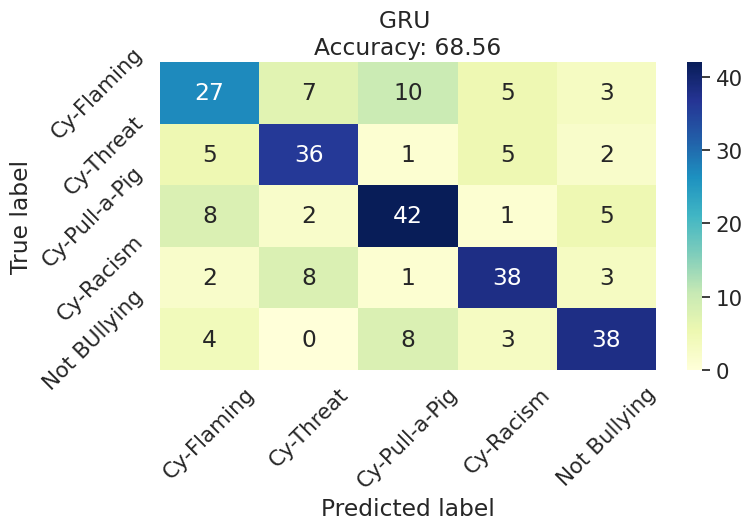

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
# load the Saved model from directory
model = load_model(path+"Model.h5")
predictions = model.predict(test_padded)
y_pred = np.argmax(predictions, axis=1)

cm = confusion_matrix(testing_label_seq, y_pred) 
print(cm)

# Transform to df for easier plotting
cm_df = pd.DataFrame(cm,
                     
                     index = ['Cy-Flaming' ,'Cy-Threat', 'Cy-Pull-a-Pig','Cy-Racism','Not BUllying'], 
                     columns =  ['Cy-Flaming' ,'Cy-Threat', 'Cy-Pull-a-Pig','Cy-Racism','Not Bullying'],)

plt.figure(figsize=(8,4))
sns.heatmap(cm_df, annot=True,cmap="YlGnBu", fmt='g')
plt.title('GRU \nAccuracy: {0:.2f}'.format(accuracy_score(testing_label_seq, y_pred)*100))
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.xticks(rotation = 45)
plt.yticks(rotation = 45)
plt.show()

In [ ]:
report = pd.DataFrame(classification_report(y_true = testing_label_seq, y_pred = y_pred, output_dict=True)).transpose()
report = report.rename(index={'0': 'Cy-Flaming','1':'Cy-Threat','2':'Cy-Pull-a-Pig','3':'Cy-Racism','4':'Not Bullying'})
report[['precision','recall','f1-score']]=report[['precision','recall','f1-score']].apply(lambda x: round(x*100,2))
report
     

,precision,recall,f1-score,support
Cy-Flaming,58.70,51.92,55.10,52.000000
Cy-Threat,67.92,73.47,70.59,49.000000
Cy-Pull-a-Pig,67.74,72.41,70.00,58.000000
Cy-Racism,73.08,73.08,73.08,52.000000
Not Bullying,74.51,71.70,73.08,53.000000
accuracy,68.56,68.56,68.56,0.685606
macro avg,68.39,68.52,68.37,264.000000
weighted avg,68.40,68.56,68.40,264.000000


In [ ]:
!pip install tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


#ROC

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have a DataFrame called 'data' with columns 'text' and 'label'
# and a variable 'num_category' with the number of classes (5 in your case)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data['text'], data['label'], test_size=0.2, random_state=42)

# Tokenize the text data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

# Convert text to sequences
X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_test_sequences = tokenizer.texts_to_sequences(X_test)

# Pad sequences to have the same length
max_length = 109
X_train_padded = pad_sequences(X_train_sequences, maxlen=max_length)
X_test_padded = pad_sequences(X_test_sequences, maxlen=max_length)

# One-hot encode the target labels
y_train_onehot = np.eye(5)[y_train.astype(int)]
y_test_onehot = np.eye(5)[y_test.astype(int)]

# Obtain the predicted probabilities from your trained model
y_pred_prob = model.predict(X_test_padded)

# Compute the false positive rate (FPR), true positive rate (TPR), and thresholds for each class
fpr = {}
tpr = {}
roc_auc = {}

for i in range(5):
    fpr[i], tpr[i], _ = roc_curve(y_test_onehot[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot the ROC curve for each class
plt.figure(figsize=(10, 6))
colors = ['b', 'g', 'r', 'c', 'm']
for i in range(5):
    plt.plot(fpr[i], tpr[i], color=colors[i], lw=2, label='Class %d (AUC = %0.2f)' % (i, roc_auc[i]))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


ValueError: ignored